## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:Белозёров Михаил Сергеевич

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.nn.functional as f


%matplotlib inline

/Users/mikhailbelozerov/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)

In [3]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

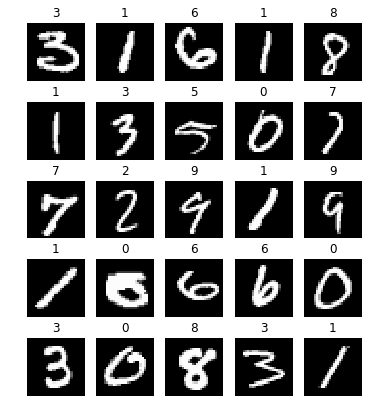

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [5]:
def init_layer(layer, mean=0, std=0.1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

def forward_hook(self, input_, output):
    std = input_[0].std().data[0]
    print 'forward', std

def backward_hook(self, grad_input, grad_output):
    std = grad_input[1].std().data[0]
    print 'backward', std

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [6]:
class myNN(nn.Module):
    def __init__(self, init_layer):
        super(myNN, self).__init__()
        layer = nn.Linear(784, 500)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)
        init_layer(layer)
        layers = [layer]
        layers.append (nn.Tanh ())
        for i in range (0, 10):
            layer = nn.Linear(500, 500)
            layer.register_forward_hook(forward_hook)
            layer.register_backward_hook(backward_hook)
            init_layer(layer)
            layers.append (layer)
            layers.append (nn.Tanh ())
            
        layer = nn.Linear(500, 10)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)
        init_layer(layer)
        layers.append (layer)
        layers.append (nn.LogSoftmax())
        self.linear_layers = nn.Sequential(*layers)
    def forward (self, X):
        return self.linear_layers (X)

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [7]:
##### YOUR CODE HERE #####
def test_reg (init_layer):
    my_nn = myNN (init_layer)


    for images_train, labels_train in train_loader:
        n_objects = 100
        X = Variable(images_train[:n_objects], requires_grad=True).view(n_objects, -1)
        y = Variable(labels_train[:n_objects], requires_grad=False)
        activations = my_nn(X)
        loss_fn = torch.nn.NLLLoss()
        optimizer = torch.optim.Adam(my_nn.parameters (), lr=0.001) 
        loss = loss_fn(activations, y)
        loss.backward()
        break

In [8]:
test_reg (init_layer)

forward 1.00613951683
forward 0.984783768654
forward 0.981730043888
forward 0.982196092606
forward 0.981765508652
forward 0.980926454067
forward 0.98152077198
forward 0.981136202812
forward 0.981257200241
forward 0.982105672359
forward 0.981149017811
forward 0.981944262981
backward 0.0130865545943
backward 0.0459733940661
backward 0.167957499623
backward 0.602916777134
backward 2.05914926529
backward 6.89683389664
backward 23.7764225006
backward 83.9314880371
backward 280.113891602
backward 993.303527832
backward 3411.87158203
backward 10933.9814453


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [9]:
##### YOUR CODE HERE #####
import math
def init_layer_glorot(layer):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    std = math.sqrt (6.) / (weight.shape[0] + weight.shape[1])
    weight.uniform_(-std,std)

In [10]:
def init_layer_he(layer):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(0,2. / (weight.shape[0]))

In [11]:
print "GLOROT:"
test_reg (init_layer_glorot)
print ""
print "HE:"
test_reg (init_layer_he)

GLOROT:
forward 0.995755970478
forward 0.0310155153275
forward 0.000979430042207
forward 3.04703462461e-05
forward 9.631961575e-07
forward 3.00759701588e-08
forward 9.31036414631e-10
forward 2.99175718921e-11
forward 9.37628663947e-13
forward 2.92503312695e-14
forward 9.35950019134e-16
forward 2.99613883766e-17
backward 2.62667253992e-05
backward 8.3752070168e-07
backward 2.63990997951e-08
backward 8.2320772421e-10
backward 2.57610807686e-11
backward 8.24999790705e-13
backward 2.6235812161e-14
backward 8.407991024e-16
backward 2.7093164418e-17
backward 8.40922150479e-19
backward 2.63851002177e-20
backward 6.51608346851e-22

HE:
forward 0.984281480312
forward 0.108745582402
forward 0.00999993551522
forward 0.000878700637259
forward 7.8891600424e-05
forward 6.98048052072e-06
forward 6.20904756943e-07
forward 5.54778161188e-08
forward 4.9089696752e-09
forward 4.44241421427e-10
forward 3.95327520719e-11
forward 3.45665141475e-12
backward 0.0018553918926
backward 0.000166845798958
backward 

<i> 1.4 Сделайте выводы по первой части </i>

Проблема взрывающихся градиентов была решена, но достичь сохранения нормы градиента не вышло - теперь он затухает. Для нелинейности  tanh лучше подходит He благодаря меньшей скорости убывания градиента

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [12]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры
# не забывайте, что в pyTorch нету broadcasting (делайте .expand)

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter (torch.Tensor(input_dim, output_dim).normal_ (0,0.1), requires_grad=True)
        self.bias = nn.Parameter (torch.Tensor(1, output_dim).normal_ (0,0.0001), requires_grad=True)
        self.w_ber = Variable (torch.Tensor(input_dim, output_dim), requires_grad=False)
        self.b_ber = Variable (torch.Tensor(1, output_dim), requires_grad=False)
        self.p = p

    def forward(self, x, training=True):
        if training:
            self.w_ber.data.bernoulli_ (self.p)
            w = torch.mul (self.weight, self.w_ber)
            res = x.mm (w)
            self.b_ber.data.bernoulli_ (self.p)
            b = torch.mul (self.bias, self.b_ber)
            return res + b
        else:
            output = self.weight * x * self.p + self.bias * self.p
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [13]:
class myNNNODrop(nn.Module):
    def __init__(self):
        super(myNNNODrop, self).__init__()
        layers = []
        
        layers.append (nn.Linear (784, 200))
        layers.append (nn.ReLU ())
        layers.append (nn.Linear (200, 200))
        layers.append (nn.ReLU ())
        layers.append (nn.Linear (200, 10))
        layers.append (nn.LogSoftmax())
        self.linear_layers = nn.Sequential(*layers)
        self.training = True
    def forward (self, X):
        return self.linear_layers (X)

In [14]:
class myNNDropConnect(nn.Module):
    def __init__(self):
        super(myNNDropConnect, self).__init__()
        layers = []
        
        layers.append (DropConnect (784, 200))
        layers.append (nn.ReLU ())
        layers.append (DropConnect (200, 200))
        layers.append (nn.ReLU ())
        layers.append (DropConnect (200, 10))
        layers.append (nn.LogSoftmax())
        self.linear_layers = nn.Sequential(*layers)
        self.training = True
    def forward (self, X):
        return self.linear_layers (X)

In [15]:
class myNNDropOut(nn.Module):
    def __init__(self):
        super(myNNDropOut, self).__init__()
        layers = []
        layers.append (nn.Linear (784, 200))
        layers.append (nn.Dropout ())
        layers.append (nn.ReLU ())
        layers.append (nn.Linear (200, 200))
        layers.append (nn.Dropout ())
        layers.append (nn.ReLU ())
        layers.append (nn.Linear (200, 10))
        layers.append (nn.LogSoftmax())
        self.linear_layers = nn.Sequential(*layers)
        self.training = True
    def forward (self, X):
        return self.linear_layers (X)

In [16]:
import sys
loss_fn = torch.nn.NLLLoss()


def train_drop_connect (my_nn, max_epoch=10):
    optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001) 
    my_nn.training = True
    loss_m = []
    for epoch in xrange (max_epoch):
        for images_train, labels_train in train_loader:
            optimizer.zero_grad ()
            X = Variable(images_train, requires_grad=True).view(images_train.size(0), -1)
            y = Variable(labels_train, requires_grad=False)
            activations = my_nn(X)
            loss = loss_fn(activations, y)
            loss_m.append (loss.data.mean ())
            sys.stdout.write (('\r Epoch:{}/{} -- Loss:{}').format (epoch, max_epoch, loss_m[-1]))
            loss.backward()
            optimizer.step ()
    plt.plot (loss_m)
    plt.show ()

def test_drop_connect (my_nn):
    error = []
    my_nn.training = False


    for x, y in test_loader:
            X = Variable(x).view(x.size(0), -1)
            y = Variable(y, requires_grad=False)
            output = my_nn.forward(X)
            loss = loss_fn(output, y)
            error.append (loss.data.mean ())
    plt.hist (error, log=True, bins=1000)
    print "error mean:", np.array (error).mean ()

 Epoch:49/50 -- Loss:0.0714037343862

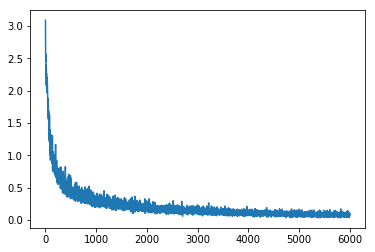


error mean: 0.113414068863


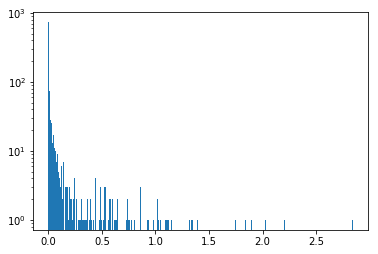

In [17]:
my_nn = myNNDropConnect ()

train_drop_connect (my_nn, max_epoch=50)
print 
test_drop_connect (my_nn)

 Epoch:49/50 -- Loss:0.0487825796008

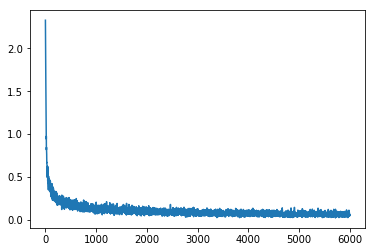


error mean: 0.143876534825


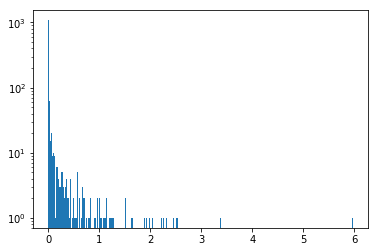

In [18]:
my_nn = myNNDropOut ()

train_drop_connect (my_nn, max_epoch=50)
print 
test_drop_connect (my_nn)

 Epoch:9/10 -- Loss:0.03187799453741

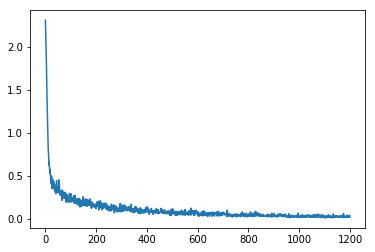


error mean: 0.0668627486979


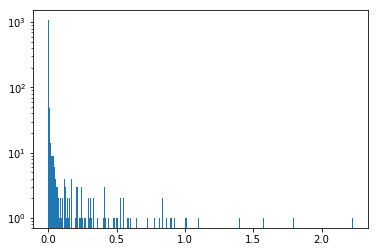

In [19]:
my_nn = myNNNODrop ()

train_drop_connect (my_nn)
print 
test_drop_connect (my_nn)

<i> 2.3 Сделайте выводы по третьей части </i>

Лучше всех справилась сеть без вероятностей 😭

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [20]:
class LayerNorm(nn.Module):

    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        eps = 1e-8
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return (x - mean) / (std + self.eps)

In [21]:
# полезные функции: .std(dim), .mean(dim)
# не забывайте, что в pyTorch нету broadcasting (делайте .expand)

class LayerNormalization(nn.Module):
    def forward(self, x):
        return f.normalize (x)

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [22]:
class myNNLayerNorm(nn.Module):
    def __init__(self):
        super(myNNLayerNorm, self).__init__()
        layers = []
        layers.append (nn.Linear (784, 200))
        layers.append (LayerNormalization ())
        layers.append (nn.ReLU ())
        layers.append (nn.Linear (200, 200))
        layers.append (LayerNormalization ())
        layers.append (nn.ReLU ())
        layers.append (nn.Linear (200, 10))
        layers.append (nn.LogSoftmax())
        self.linear_layers = nn.Sequential(*layers)
        self.training = True
    def forward (self, X):
        return self.linear_layers (X)

In [23]:
class myNNBatchNorm(nn.Module):
    def __init__(self):
        super(myNNBatchNorm, self).__init__()
        layers = []
        layers.append (nn.Linear (784, 200))
        layers.append (nn.BatchNorm2d (200))
        layers.append (nn.ReLU ())
        layers.append (nn.Linear (200, 200))
        layers.append (nn.BatchNorm2d (200))
        layers.append (nn.ReLU ())
        layers.append (nn.Linear (200, 10))
        layers.append (nn.LogSoftmax())
        self.linear_layers = nn.Sequential(*layers)
        self.training = True
    def forward (self, X):
        return self.linear_layers (X)

 Epoch:9/10 -- Loss:0.0682868286967

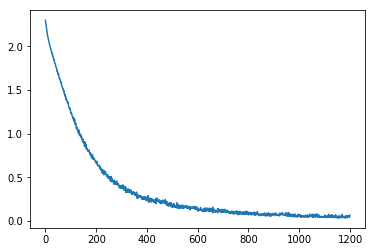


error mean: 0.0956569251278


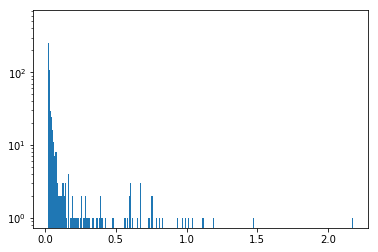

In [24]:
my_nn = myNNLayerNorm ()

train_drop_connect (my_nn)
print 
test_drop_connect (my_nn)

 Epoch:9/10 -- Loss:0.00959280133247

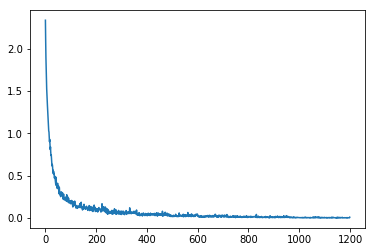


error mean: 0.778203374607


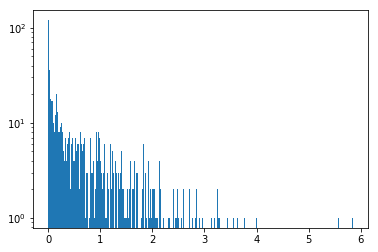

In [25]:
my_nn = myNNBatchNorm ()

train_drop_connect (my_nn)
print 
test_drop_connect (my_nn)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: